## ML Training

Train models to be used in simulate_prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path
import h5py
import pickle
from tqdm.notebook import tqdm
import pandas as pd

from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

from src.data.file_utils import GetEmission
from src.models import predict #model
from src.utils.helpers import *

from IPython.display import clear_output

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
models = predict.list_models()
for idx, model in enumerate(models):
    print(idx, model)

0 ../models/weighted_outer_allold_set.pkl
1 ../models/weighted_outer_all1.pkl
2 ../models/lr_tv_inv_outer.pkl
3 ../models/weighted_outer_all.pkl
4 ../models/weighted_outer_allnew_half_set.pkl
5 ../models/weighted_outer_all2.pkl
6 ../models/lr_inversion_manual.pkl
7 ../models/weighted_outer_l-mode.pkl
8 ../models/weighted_outer_h-mode.pkl
9 ../models/lr.pkl
10 ../models/lr_supervised_mdl.pkl


# Data Prep

In [4]:
run_type = 'all'
prep_filename = 'weighted_outer_dataset_' + run_type
prediction_filename = 'weighted_outer_' + run_type
algorithm = 'linear'
split_ratio = 0.2

In [5]:
tv_path = Path('../data/raw') / run_type
label_path = Path('../data/labels/weighted_emission') / run_type
prep_path = Path('../data/processed/hdf5')
model_path = Path('../models')

In [6]:
tv = GetEmission(tv_path)
files = tv.list_files()
file_lengths = tv.file_lengths()
cumulative_lengths = np.insert(np.cumsum(file_lengths), 0, 0)
tv_dim = tv.load(files[0], 'vid').shape

Number of files: 26
Number of files: 26


In [38]:
ml_id = '4'
file_name = prep_filename + '.h5'

In [10]:
target_cdf = np.load('../data/processed/histogram/target_cdf.npy')
bin_edges = np.load('../data/processed/histogram/bin_edges.npy')

### Fill Out TV Image Data

In [40]:
def file_split_compile_prep(split_ratio,
                      prep_path,
                      prep_filename,
                      label_path,
                      files):
    # split by file
    train_files, test_files = train_test_split(files, test_size=split_ratio, random_state=182)
    #train_files = files # use when wanting to make a deployable model

    points_train = []
    tv_train = []
    points_test = []
    tv_test = []

    for _, file in enumerate(train_files):
        print('Appending Training: ',file.stem)
        frames = tv.load(file, 'frames').astype('int')
        tv_image = tv.load(file, 'vid')[frames]
        tv_image = tv_image[:, ::2, ::3]
        tv_image = noisify(tv_image).astype(np.float32) / 256
        tv_image = match_images_to_histogram(tv_image, target_cdf, bin_edges)
        tv_image = normalize_image(tv_image) * 256
        
        test_label_file = (label_path / file.stem).with_suffix('.pkl')
        with open(test_label_file, 'rb') as f:
            labels = pickle.load(f)
            
        for i in range(len(frames)):
            tv_train.append(tv_image[i])
            points_train.append(labels[i])
            
    for _, file in enumerate(test_files):
        print('Appending Testing: ',file.stem)
        frames = tv.load(file, 'frames').astype('int')
        tv_image = tv.load(file, 'vid')[frames]
        tv_image = tv_image[:, ::2, ::3]
        tv_image = noisify(tv_image).astype(np.float32) / 256
        tv_image = match_images_to_histogram(tv_image, target_cdf, bin_edges)
        tv_image = normalize_image(tv_image) * 256
        
        test_label_file = (label_path / file.stem).with_suffix('.pkl')
        with open(test_label_file, 'rb') as f:
            labels = pickle.load(f)
            
        for i in range(len(frames)):
            tv_test.append(tv_image[i])
            points_test.append(labels[i])
            
    with h5py.File(prep_path / str(prep_filename + '.h5'), 'w') as f:
        f.create_dataset('vid_train', data=tv_train)
        f.create_dataset('points_train', data=points_train)
        f.create_dataset('vid_test', data=tv_test)
        f.create_dataset('points_test', data=points_test)
    print(str(prep_path / str(prep_filename + '.h5')),'has been saved!')

In [41]:
file_split_compile_prep(split_ratio, prep_path, prep_filename, label_path, files)

Appending Training:  emission_structure_pu_cam240perp_189448
Appending Training:  emission_structure_pu_cam240perp_199171
Appending Training:  emission_structure_pu_cam240perp_190113
Appending Training:  emission_structure_pu_cam240perp_189100
Appending Training:  emission_structure_pu_cam240perp_189451
Appending Training:  emission_structure_pu_cam240perp_189057
Appending Training:  emission_structure_pu_cam240perp_189093
Appending Training:  emission_structure_pu_cam240perp_190115
Appending Training:  emission_structure_pu_cam240perp_189081
Appending Training:  emission_structure_pu_cam240perp_189101
Appending Training:  emission_structure_pu_cam240perp_199166
Appending Training:  emission_structure_pu_cam240perp_189061
Appending Training:  emission_structure_pu_cam240perp_189094
Appending Training:  emission_structure_pu_cam240perp_199172
Appending Training:  emission_structure_pu_cam240perp_189090
Appending Training:  emission_structure_pu_cam240perp_199351
Appending Training:  emi

# Train Test Deploy

## Linear Regression

### Train

In [42]:
file_name = prep_filename + '.h5'

with h5py.File(prep_path / file_name, 'r') as f:
    vid_train = f['vid_train'][:]
    points_train = f['points_train'][:]
    vid_test = f['vid_test'][:]
    points_test = f['points_test'][:]

files = tv.list_files()
elevation = tv.load(files[0], 'elevation')[0]
radii = tv.load(files[0], 'radii')[0]
vid_shape = tv.load(files[0], 'vid')[0].shape

X_train = flatten(vid_train)
X_test = flatten(vid_test)
y_train = points_train
y_test = points_test

Number of files: 26


In [43]:
mdl = LinearRegression()
mdl.fit(X_train, y_train)

LinearRegression()

### Test

In [44]:
r_predict = mdl.predict(X_test)
err = mean_absolute_error(r_predict,y_test) * 100
print(f'Mean Absolute Error: {err}')
print('Root Mean Squared Error: ', root_mean_squared_error(r_predict, y_test)*100)

Mean Absolute Error: 0.7176949969778708
Root Mean Squared Error:  1.2977087823048965


### Deploy

In [39]:
coefficients = mdl.coef_
intercept = mdl.intercept_

coefficients_file = model_path / f"{prediction_filename}{ml_id}_coefficients.txt"
with open(coefficients_file, 'w') as f:
    for coef in coefficients:
        f.write(f"{coef}\n")
print(coefficients_file, "has been saved!")
print("Intercept (Please Write Down):", intercept)

../models/weighted_outer_all4_coefficients.txt has been saved!
Intercept (Please Write Down): -1.0988472


In [22]:
# Optional (Predicting and Saving Points with Model)
weight_ml_point_save_path = Path('../output/value/weight_ml_point') / run_type / ml_id
weight_ml_point_save_path.mkdir(parents=True, exist_ok=True)

for file in files:
    
    clear_output(wait=True)
    
    print('Shot:', file.stem.split('_')[-1])
    point_save_name = weight_ml_point_save_path / f"{file.stem}.pkl"
    label_file = (label_path / file.stem).with_suffix('.pkl')
    with open(label_file, 'rb') as f:
        labels_cartesian = pickle.load(f)
    frames = tv.load(file, 'frames').astype('int')
    tv_image = tv.load(file, 'vid')[frames]
    tv_flatten = flatten(tv_image)
    
    prediction_cartesian = mdl.predict(tv_flatten)
    txt_file = (label_path / file.stem).with_suffix('.txt')
    with open(txt_file, 'w') as f:
        for point in prediction_cartesian:
            f.write(f"{point},")
    print(f"Saved {txt_file}")

Shot: 189101
Saved ../data/labels/weighted_emission/h-mode/emission_structure_pu_cam240perp_189101.txt


### Loading Deployed Model / Predicted Points

In [43]:
# how to load coefficients
coefficients = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients.append(float(line.strip()))
        
# how to load points
with open(label_file, 'rb') as f:
    labels_cartesian = pickle.load(f)
    print(len(labels_cartesian))

../models/weighted_outer_all2_coefficients.txt
172800


## Deep Learning

# Save Video

## Linear Regression

In [18]:
tv = GetEmission(tv_path)
files = tv.list_files()
file_lengths = tv.file_lengths()
cumulative_lengths = np.insert(np.cumsum(file_lengths), 0, 0)
tv_dim = tv.load(files[0], 'vid').shape

# with open(f"{model_path / prediction_filename}.pkl", 'rb') as f:
#     model = pickle.load(f)
    
mp4_save_path = Path('../outputs/video/weighted_ml') / run_type
mp4_save_path.mkdir(parents=True, exist_ok=True)

In [23]:
for file in files:
    
    clear_output(wait=True)
    
    print('Shot:', file.stem.split('_')[-1])
    mp4_save_name = mp4_save_path / f"{file.stem.split('_')[-1]}.mp4"
    label_file = (label_path / file.stem).with_suffix('.pkl')
    with open(label_file, 'rb') as f:
        labels_cartesian = pickle.load(f)
    frames = tv.load(file, 'frames').astype('int')
    tv_image = tv.load(file, 'vid')[frames]
    inverted = tv.load(file, 'inverted')
    elevation = tv.load(file, 'elevation')[0]
    
    prediction_cartesian = model.predict(tv_image)
    
    prediction = get_index(prediction_cartesian, elevation, )
    labels = get_index(labels_cartesian, elevation)

    # Initialize figure and axes
    print("Animating...")
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    img = ax.imshow(inverted[0], origin='lower')
    hline_label = ax.axhline(labels[0], c='lime', label='label')
    hline_prediction = ax.axhline(prediction[0], c='red', label='prediction', ls='--')
    ax.legend(loc='upper right')
    ax.set_title(f'Inverted View: 0')

    fig.suptitle(f"Shot {file.stem.split('_')[-1]}")
    frames = []
    # Function to update the plot
    def update(idx):
        img.set_data(inverted[idx])
        
        hline_label.set_ydata([labels[idx]])
        hline_prediction.set_ydata([prediction[idx]])
        
        ax.set_title(f'Inverted View: {idx}')
        
        return img, hline_label, hline_prediction
        
    # Create the animation using FuncAnimation
    ani = animation.FuncAnimation(fig, update, frames=range(inverted.shape[0]), blit=True, repeat=False)

    # Save the animation as an MP4 file
    print("Saving MP4...")
    FFwriter = animation.FFMpegWriter(fps=30, extra_args=["-vcodec", "libx264"])
    ani.save(mp4_save_name, writer=FFwriter)

    plt.close(fig)

Shot: 199354
Animating...
Saving MP4...


## Deep Learning

In [66]:
ml_id = ''
tv = GetEmission(tv_path)
files = tv.list_files()
file_lengths = tv.file_lengths()
cumulative_lengths = np.insert(np.cumsum(file_lengths), 0, 0)
tv_dim = tv.load(files[0], 'vid').shape

mdl2 = load_model(f"{model_path / prediction_filename}{ml_id}.keras")
    
mp4_save_path = Path('../outputs/video/weighted_dl') / run_type
mp4_save_path.mkdir(parents=True, exist_ok=True)

weight_ml_point_save_path = Path('../data/processed/weight_ml_point') / ml_id

Shot: 189057
Animating...
Saving MP4...


FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

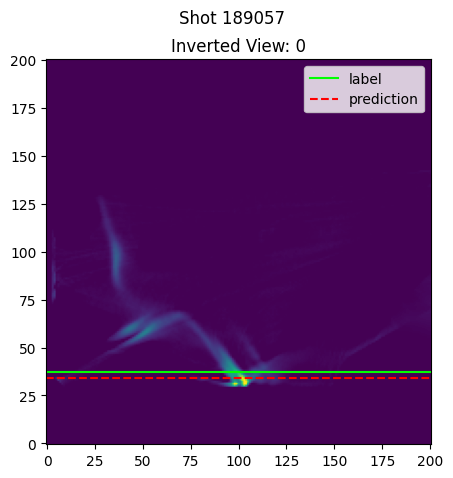

In [67]:
for file in files:
    
    clear_output(wait=True)
    
    print('Shot:', file.stem.split('_')[-1])
    mp4_save_name = mp4_save_path / f"{file.stem.split('_')[-1]}.mp4"
    label_file = (label_path / file.stem).with_suffix('.pkl')
    point_save_name = weight_ml_point_save_path / f"dl{file.stem}.pkl"
    with open(label_file, 'rb') as f:
        labels_cartesian = pickle.load(f)
    frames = tv.load(file, 'frames').astype('int')
    tv_image = tv.load(file, 'vid')[frames]
    vid_input = np.expand_dims(tv_image, axis=3)
    inverted = tv.load(file, 'inverted')
    elevation = tv.load(file, 'elevation')[0]
    with open(point_save_name, 'rb') as f:
        prediction_cartesian = pickle.load(f)
    prediction = get_index(prediction_cartesian, elevation, )
    labels = get_index(labels_cartesian, elevation)

    # Initialize figure and axes
    print("Animating...")
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    img = ax.imshow(inverted[0], origin='lower')
    hline_label = ax.axhline(labels[0], c='lime', label='label')
    hline_prediction = ax.axhline(prediction[0], c='red', label='prediction', ls='--')
    ax.legend(loc='upper right')
    ax.set_title(f'Inverted View: 0')

    fig.suptitle(f"Shot {file.stem.split('_')[-1]}")
    frames = []
    # Function to update the plot
    def update(idx):
        img.set_data(inverted[idx])
        
        hline_label.set_ydata([labels[idx]])
        hline_prediction.set_ydata([prediction[idx]])
        
        ax.set_title(f'Inverted View: {idx}')
        
        return img, hline_label, hline_prediction
        
    # Create the animation using FuncAnimation
    ani = animation.FuncAnimation(fig, update, frames=range(inverted.shape[0]), blit=True, repeat=False)

    # Save the animation as an MP4 file
    print("Saving MP4...")
    FFwriter = animation.FFMpegWriter(fps=30, extra_args=["-vcodec", "libx264"])
    ani.save(mp4_save_name, writer=FFwriter)

    plt.close(fig)